## Objective - To predict whether a customer will subscribe for a term deposit

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import sklearn
import xgboost
import lightgbm
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from lazypredict.Supervised import LazyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score 
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2, RFECV
from scipy.stats import chi2_contingency 



## Loading Dataset

In [2]:
data_url = ("/Users/vidyakumar/Desktop/python/apziva/term-deposit-marketing-2020.csv")

In [3]:
def load_data():
    data = pd.read_csv(data_url)
    return data

data = load_data()

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


#### Total rows - 40,000. There are no missing values, hence imputation is not required.

## Exploratory Data Analysis

In [5]:
#creating age groups for visualization
cut_labels = ['age_18_25', 'age_26_33', 'age_34_41', 'age_42_49','age_50_57', 'age_58_65', 'age_66_73', 'age_74_89','age_90&abv']
cut_bins = [18, 25, 33, 41, 49, 57, 65, 73, 89, 100]
data['age_categ'] = pd.cut(data['age'], bins=cut_bins, labels=cut_labels)

data.tail(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y,age_categ
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no,age_50_57
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes,age_26_33
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes,age_50_57
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no,age_34_41
39999,38,technician,married,secondary,no,1442,yes,no,cellular,3,jun,113,1,no,age_34_41


In [6]:
#creating campaign groups for visualization
cut_labels1 = ['camp_1_5', 'camp_6_10', 'camp_11_15', 'camp_16_30','camp_31_50', 'camp_51_65']
cut_bins1 = [0, 5, 10, 15, 30, 50, 65]
data['camp_categ'] = pd.cut(data['campaign'], bins=cut_bins1, labels=cut_labels1)

data.tail(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y,age_categ,camp_categ
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no,age_50_57,camp_1_5
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes,age_26_33,camp_1_5
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes,age_50_57,camp_1_5
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no,age_34_41,camp_1_5
39999,38,technician,married,secondary,no,1442,yes,no,cellular,3,jun,113,1,no,age_34_41,camp_1_5


#### Dummy variables - Convert categorical data into numeric

In [7]:
data_job = pd.get_dummies(data['job'], prefix = 'job', prefix_sep = '_', drop_first = True)
data_marital = pd.get_dummies(data['marital'], prefix = 'marital', prefix_sep = '_', drop_first = True)
data_education = pd.get_dummies(data['education'], prefix = 'education', prefix_sep = '_', drop_first = True)
data_default = pd.get_dummies(data['default'], prefix = 'default', prefix_sep = '_', drop_first = True)
data_housing = pd.get_dummies(data['housing'], prefix = 'housing', prefix_sep = '_', drop_first = True)
data_loan = pd.get_dummies(data['loan'], prefix = 'loan', prefix_sep = '_', drop_first = True)
data_contact = pd.get_dummies(data['contact'], prefix = 'contact', prefix_sep = '_', drop_first = True)
data_month = pd.get_dummies(data['month'], prefix = 'month', prefix_sep = '_', drop_first = True)
data_y = pd.get_dummies(data['y'], prefix = 'y', prefix_sep = '_', drop_first = True)

In [8]:
# Concat original data frame and dummy columns
data_dc = data.drop(columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y','age_categ','camp_categ'])
data_dc = pd.concat([data_dc, data_job, data_marital, data_education, data_default, data_housing, data_loan, data_contact, data_month, data_y], axis = 1)

In [9]:
data_dc.describe()

,age,balance,day,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,y_yes
count,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,...,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00
mean,40.54,1274.28,16.02,254.82,2.88,0.23,0.04,0.03,0.20,0.04,...,0.00,0.06,0.03,0.16,0.12,0.01,0.34,0.09,0.00,0.07
std,9.64,2903.77,8.28,259.37,3.24,0.42,0.18,0.16,0.40,0.19,...,0.02,0.23,0.17,0.37,0.32,0.08,0.47,0.29,0.04,0.26
min,19.00,-8019.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,33.00,54.00,8.00,100.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,39.00,407.00,17.00,175.00,2.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,48.00,1319.00,21.00,313.00,3.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
max,95.00,102127.00,31.00,4918.00,63.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


#### Creating various plots for visualization

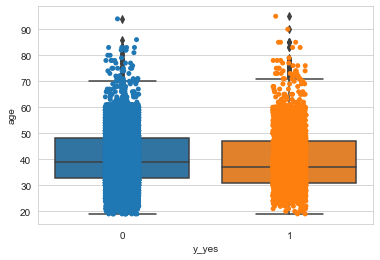

In [10]:
#age and deposit
sns.set_style('whitegrid')
ax= sns.boxplot(x='y_yes',y='age', data=data_dc)
ax = sns.stripplot(x='y_yes',y='age', data=data_dc)

[Text(0, 0, 'management'),
 Text(1, 0, 'technician'),
 Text(2, 0, 'entrepreneur'),
 Text(3, 0, 'blue-collar'),
 Text(4, 0, 'unknown'),
 Text(5, 0, 'retired'),
 Text(6, 0, 'admin'),
 Text(7, 0, 'services'),
 Text(8, 0, 'self-employed'),
 Text(9, 0, 'unemployed'),
 Text(10, 0, 'housemaid'),
 Text(11, 0, 'student')]

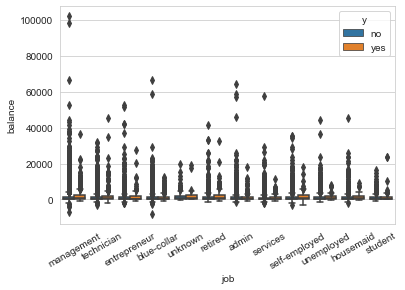

In [11]:
#job and deposit
sns.set_style('whitegrid')
ax= sns.boxplot(x='job',y='balance',hue="y",data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

<AxesSubplot:title={'center':'Job and Deposit'}>

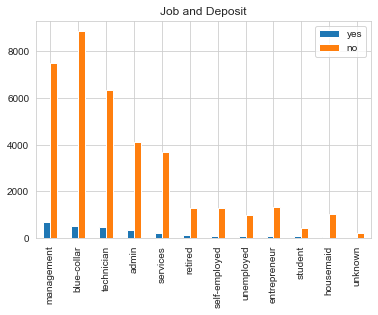

In [12]:
#job and deposit
job_df = pd.DataFrame()

job_df['yes'] = data[data['y'] == 'yes']['job'].value_counts()
job_df['no'] = data[data['y'] == 'no']['job'].value_counts()

job_df.plot.bar(title = 'Job and Deposit')

#### Customers with 'blue-collar' jobs are less likely to subscribe for term deposit; which is also proven by their negative balance shown on the boxplot above

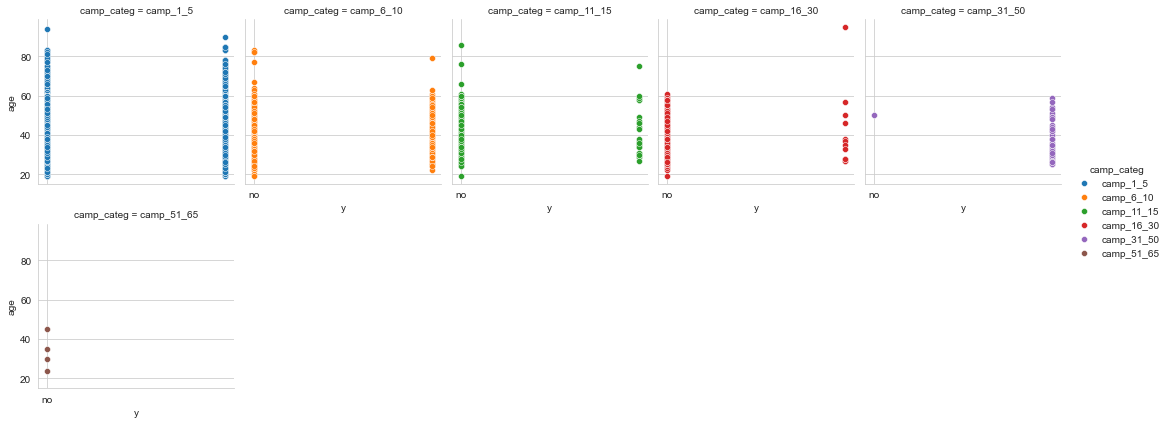

In [13]:
#campaign and deposit
grid = sns.FacetGrid(data, col = "camp_categ", hue = "camp_categ", col_wrap=5)
grid.map(sns.scatterplot, "y", "age")

grid.add_legend()

plt.show()


#### People who subscribed for term deposit tend to have fewer number of contacts during this campaign

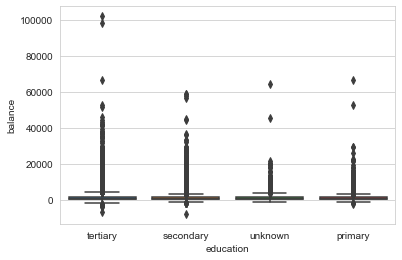

In [14]:
#balance and education
sns.set_style('whitegrid')
ax= sns.boxplot(x='education',y='balance', data=data)


In [15]:
#balance and education
df = data[['education', 'balance']]
rslt_df = df[df['balance'] <= 0] 
rslt_df.groupby(['education']).count()

,balance
education,
primary,1107
secondary,3879
tertiary,1704
unknown,250


In [16]:
df.groupby(['education']).count()

,balance
education,
primary,6270
secondary,20993
tertiary,11206
unknown,1531


#### People with Secondary education tend to have negative balance - 18.5% of secondary educated population have negative balance, followed by primary educated population - 17.7% have negative balance

           yes     no
married   1478  22908
single    1027   9862
divorced   391   4334


<AxesSubplot:title={'center':'Marital and Deposit'}>

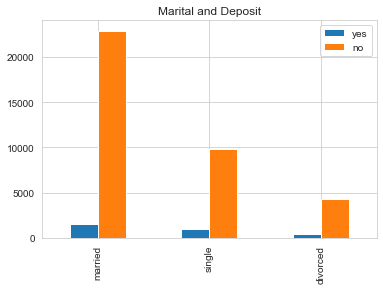

In [17]:
#marital status and deposit
mar_df = pd.DataFrame()

mar_df['yes'] = data[data['y'] == 'yes']['marital'].value_counts()
mar_df['no'] = data[data['y'] == 'no']['marital'].value_counts()
print(mar_df)

mar_df.plot.bar(title = 'Marital and Deposit')

#### Married customers are less likely to subscribe for the term deposit

In [18]:
#Month and total call duration
df_tot = data[['month', 'duration']]
df_tot = df_tot.groupby(['month']).sum()
df_tot

,duration
month,
apr,804955
aug,1184332
dec,1777
feb,553239
jan,316900
jul,1693511
jun,1135382
mar,57184
may,3517672


In [19]:
#Month and avg call duration
df1 = data[['month', 'duration','y']]
df_mth=df1.groupby(['month','y']).mean()
df_mth


duration
month y            
apr   no     257.75
      yes    489.21
aug   no     193.00
      yes    810.45
dec   no     138.17
      yes    119.00
feb   no     208.36
      yes    501.90
jan   no     243.42
      yes   1049.63
jul   no     226.49
      yes    873.59
jun   no     206.93
      yes    736.84
mar   no     150.26
      yes    297.60
may   no     230.09
      yes    740.88
nov   no     218.71
      yes    743.49
oct   no     281.19
      yes    345.29

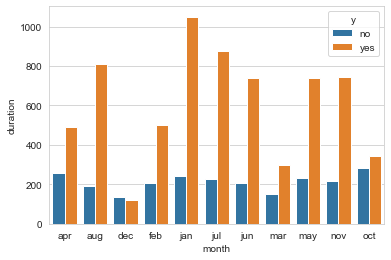

In [20]:
#Month and avg call duration
df_mth.reset_index(inplace=True)
sns.barplot(x='month',y='duration',hue='y',data = df_mth)
plt.show()

#### 1. Most of the calls are in the summer months with peak in the month of May
#### 2. Maximum avg duration of calls to get customers to subscribe for term deposit - January

[Text(0, 0, 'yes'), Text(1, 0, 'no')]

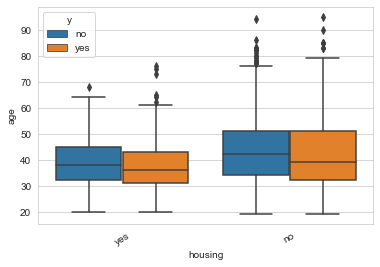

In [21]:
#housing and deposit
sns.set_style('whitegrid')
ax= sns.boxplot(x='housing',y='age',hue="y",data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

#### Chi-Sq tests to understand various relationships of the data

In [22]:
#housing and deposit
crosstab1 = pd.crosstab(data['housing'], data['y'])
crosstab1

y,no,yes
housing,,
no,14537,1432
yes,22567,1464


In [23]:
# column percentages
colsum1=crosstab1.sum(axis=0)
colpct1=crosstab1/colsum1
print(colpct1)

y         no  yes
housing          
no      0.39 0.49
yes     0.61 0.51


In [24]:
# chi-square
print ('chi-square value, p value, expected counts')
cs1= scipy.stats.chi2_contingency(crosstab1)
print(cs1)

chi-square value, p value, expected counts
(117.66942117763818, 2.048342664339848e-27, 1, array([[14812.8444,  1156.1556],
       [22291.1556,  1739.8444]]))


In [25]:
#loan and deposit
crosstab = pd.crosstab(data['loan'], data['y'])
crosstab

y,no,yes
loan,,
no,30554,2516
yes,6550,380


In [26]:
# column percentages
colsum=crosstab.sum(axis=0)
colpct=crosstab/colsum
print(colpct)

y      no  yes
loan          
no   0.82 0.87
yes  0.18 0.13


In [27]:
# chi-square
print ('chi-square value, p value, expected counts')
cs= scipy.stats.chi2_contingency(crosstab)
print(cs)

chi-square value, p value, expected counts
(38.19687165861611, 6.395487199647575e-10, 1, array([[30675.732,  2394.268],
       [ 6428.268,   501.732]]))


#### Both loan and housing are statistically significant variables in predicting subscription of term deposit

## Data Manipulation

#### Scaling data

In [28]:
#scaling age
from sklearn.preprocessing import MinMaxScaler 
minmaxscaler = MinMaxScaler(feature_range=(5, 10)) 
minmaxscaler.fit(data_dc[['age']]) 
data_dc['scaled_age'] = minmaxscaler.transform(data_dc[['age']]) 
data_dc['scaled_age'].describe()

count   40000.00
mean        6.42
std         0.63
min         5.00
25%         5.92
50%         6.32
75%         6.91
max        10.00
Name: scaled_age, dtype: float64

In [29]:
#scaling balance column
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

data_dc['scaled_balance'] = scaler.fit_transform(data_dc[['balance']])
data_dc['scaled_balance'].describe()


count   40000.00
mean        0.01
std         0.03
min        -0.08
25%         0.00
50%         0.00
75%         0.01
max         1.00
Name: scaled_balance, dtype: float64

In [30]:
#scaling duration
data_dc['duration'].mean()
data_dc['avg_zscore_duration'] = (data_dc['duration'] - data_dc['duration'].mean())/data_dc['duration'].std(ddof=0)
data_dc.head()

,age,balance,day,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,y_yes,scaled_age,scaled_balance,avg_zscore_duration
0,58,2143,5,261,1,0,0,0,1,0,...,0,0,0,1,0,0,0,7.57,0.02,0.02
1,44,29,5,151,1,0,0,0,0,0,...,0,0,0,1,0,0,0,6.64,0.00,-0.40
2,33,2,5,76,1,0,1,0,0,0,...,0,0,0,1,0,0,0,5.92,0.00,-0.69
3,47,1506,5,92,1,1,0,0,0,0,...,0,0,0,1,0,0,0,6.84,0.01,-0.63
4,33,1,5,198,1,0,0,0,0,0,...,0,0,0,1,0,0,0,5.92,0.00,-0.22


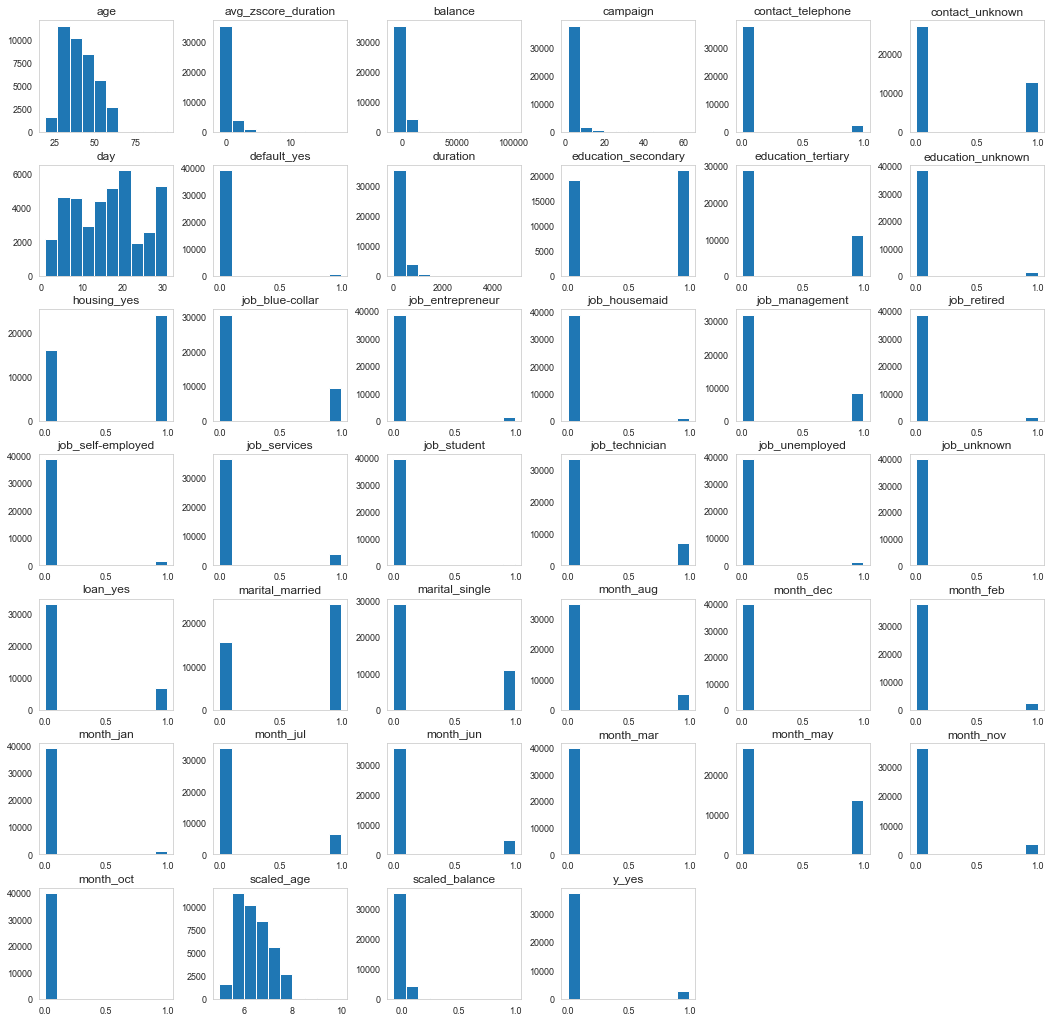

In [31]:
# Visualize numerical features using histogram
data_dc.hist(figsize = (18,18), grid = False, xlabelsize=9, ylabelsize=9)
plt.show()

In [32]:
data_dc.describe()

,age,balance,day,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,y_yes,scaled_age,scaled_balance,avg_zscore_duration
count,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,...,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00
mean,40.54,1274.28,16.02,254.82,2.88,0.23,0.04,0.03,0.20,0.04,...,0.16,0.12,0.01,0.34,0.09,0.00,0.07,6.42,0.01,0.00
std,9.64,2903.77,8.28,259.37,3.24,0.42,0.18,0.16,0.40,0.19,...,0.37,0.32,0.08,0.47,0.29,0.04,0.26,0.63,0.03,1.00
min,19.00,-8019.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,-0.08,-0.98
25%,33.00,54.00,8.00,100.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.92,0.00,-0.60
50%,39.00,407.00,17.00,175.00,2.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.32,0.00,-0.31
75%,48.00,1319.00,21.00,313.00,3.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,6.91,0.01,0.22
max,95.00,102127.00,31.00,4918.00,63.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,10.00,1.00,17.98


#### Check Class Balancing

In [33]:
#checking if its balanced dataset -- imbalanced dataset
data_dc['y_yes'].value_counts()

0    37104
1     2896
Name: y_yes, dtype: int64

#### The class is heavily skewed towards 'no' - Fraction of people will generally subscribe to a term deposit. Need to balance our class.

## Split - Training and Testing data

In [34]:
X = data_dc.drop(columns = ['y_yes'])
y = data_dc['y_yes']


In [35]:
rs=12
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rs)
print(X_train.shape)           
print(X_test.shape)

(32000, 39)
(8000, 39)


## Class balancing

#### Class balancing techniques: Oversampling, SMOTE and Undersampling

#### Random Oversampling

In [36]:
#random oversampling
ros = RandomOverSampler(random_state = rs)     
X_ros, y_ros = ros.fit_resample(X_train, y_train) 

In [37]:
pd.value_counts(y_ros) 

1    29692
0    29692
Name: y_yes, dtype: int64

#### Testing results of logistic regression with ros data

In [38]:
#logistic regression - ros
logisticRegr = LogisticRegression()
lr = logisticRegr.fit(X_ros, y_ros)
y_pred=logisticRegr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7412
           1       0.29      0.83      0.43       588

    accuracy                           0.84      8000
   macro avg       0.64      0.83      0.67      8000
weighted avg       0.93      0.84      0.87      8000



In [39]:
# predict probabilities 
y_prob=logisticRegr.predict_proba(X_test)
print(y_prob)

[[0.55046697 0.44953303]
 [0.00876457 0.99123543]
 [0.60229942 0.39770058]
 ...
 [0.66626454 0.33373546]
 [0.9524165  0.0475835 ]
 [0.92646077 0.07353923]]


In [40]:
# keep probabilities for the positive outcome only
probs = y_prob[:, 1]

In [41]:
# calculate roc auc
auc = roc_auc_score(y_test, probs)
print(auc)

0.9098701407168371


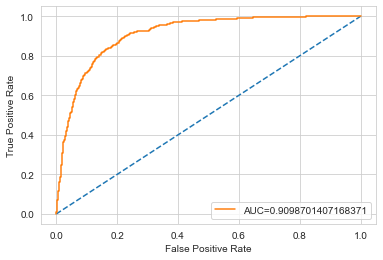

In [42]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
# show the plot
plt.show()

In [43]:
cross_val_score(logisticRegr, X_ros, y_ros, cv=5)

array([0.83135472, 0.81771491, 0.83531195, 0.83463838, 0.83386662])

#### SMOTE Balancing

In [44]:
#smote balancing
smo = SMOTE(random_state = rs)                     
X_smo, y_smo = smo.fit_resample(X_train, y_train)           

In [45]:
pd.value_counts(y_smo)                                     

1    29692
0    29692
Name: y_yes, dtype: int64

#### Testing results of logistic regression with smote data

In [46]:
#logistic regression - smote
logisticRegr = LogisticRegression()
lr_smo = logisticRegr.fit(X_smo, y_smo)
y_pred_smo=logisticRegr.predict(X_test)
print(classification_report(y_test, y_pred_smo))

              precision    recall  f1-score   support

           0       0.97      0.91      0.93      7412
           1       0.33      0.59      0.43       588

    accuracy                           0.88      8000
   macro avg       0.65      0.75      0.68      8000
weighted avg       0.92      0.88      0.90      8000



In [47]:
# predict probabilities 
y_prob_smo=logisticRegr.predict_proba(X_test)
print(y_prob_smo)

[[0.83156281 0.16843719]
 [0.0010922  0.9989078 ]
 [0.90360332 0.09639668]
 ...
 [0.53577875 0.46422125]
 [0.99777137 0.00222863]
 [0.87065776 0.12934224]]


In [48]:
# keep probabilities for the positive outcome only
probs = y_prob_smo[:, 1]

In [49]:
# calculate roc auc
auc = roc_auc_score(y_test, probs)
print(auc)

0.8592003315087503


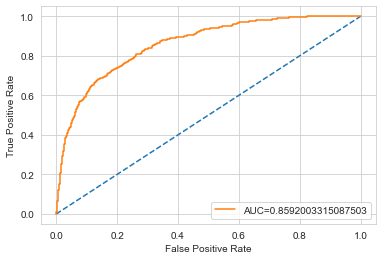

In [50]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
# show the plot
plt.show()

In [51]:
cross_val_score(logisticRegr, X_smo, y_smo, cv=5) 

array([0.8411215 , 0.89803823, 0.89896438, 0.89576492, 0.90291344])

#### Random Undersampling

In [52]:
#random undersampling
rus = RandomUnderSampler(random_state = rs)               
X_rus, y_rus = rus.fit_resample(X_train, y_train)                 

In [53]:
pd.value_counts(y_rus)

1    2308
0    2308
Name: y_yes, dtype: int64

#### Testing results of logistic regression with rus data

In [54]:
#logistic regression - rus
logisticRegr = LogisticRegression()
lr_rus = logisticRegr.fit(X_rus, y_rus)
y_pred_rus=logisticRegr.predict(X_test)
print(classification_report(y_test, y_pred_rus))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7412
           1       0.30      0.80      0.44       588

    accuracy                           0.85      8000
   macro avg       0.64      0.83      0.68      8000
weighted avg       0.93      0.85      0.88      8000



In [55]:
# predict probabilities 
y_prob_rus=logisticRegr.predict_proba(X_test)
probs = y_prob_rus[:, 1]

In [56]:
auc = roc_auc_score(y_test, probs)
print(auc)

0.9079618085766418


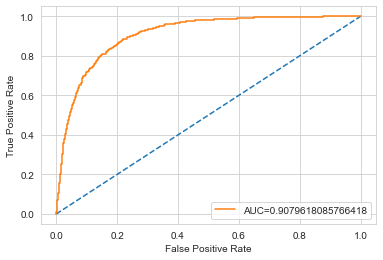

In [57]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
# show the plot
plt.show()

In [58]:
cross_val_score(logisticRegr, X_rus, y_rus, cv=5) 

array([0.80519481, 0.84073673, 0.8396533 , 0.8255688 , 0.79631636])

#### Random undersampling and Random oversampling produce best results in terms of f1 score, auc and recall values. Hence, will build more models using these datasets

## Modeling

#### Evaluation Metric - 'Recall for class 1' and 'f1 score' 
#### We would not like to miss any opportunity - minimize the number of subscribed customers predicted incorrectly. And hence need to maximize Recall.

#### 1. KNN Classifier with ros data

In [60]:
#knn classifier - ros
k_range = range(1,50)                                
scores = {}                                          
score_list = []                                     
for k in k_range:                                    
    knn = KNeighborsClassifier(n_neighbors = k)     
    knn.fit(X_ros, y_ros)                        
    y_pred_knn = knn.predict(X_test)                 
    scores[k] = f1_score(y_test, y_pred_knn)         
    score_list.append(f1_score(y_test, y_pred_knn))  


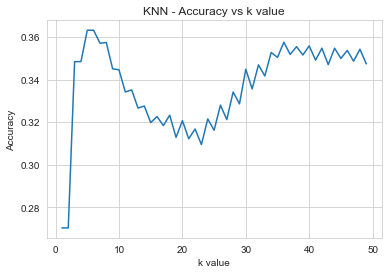

In [61]:
#identifying k value for best accuracy
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, score_list)                   
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs k value')
plt.show()

In [62]:
print(max(score_list))
print(max(scores, key=scores.get))

0.3631376851343939
5


In [63]:
#building the final knn model with k=5
knnc = KNeighborsClassifier(n_neighbors = 5)     
knf = knnc.fit(X_ros, y_ros)                        
y_pred_knn = knnc.predict(X_test) 
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      7412
           1       0.27      0.56      0.36       588

    accuracy                           0.85      8000
   macro avg       0.62      0.72      0.64      8000
weighted avg       0.91      0.85      0.88      8000



#### 2. Support Vector Machine with rus data

In [64]:
#SVC - rus
svc = SVC()                                                     
svc.fit(X_rus, y_rus)                                           
print(classification_report(y_test, svc.predict(X_test)))      

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7412
           1       0.28      0.72      0.40       588

    accuracy                           0.84      8000
   macro avg       0.63      0.79      0.66      8000
weighted avg       0.92      0.84      0.87      8000



In [65]:
cross_val_score(svc, X_rus, y_rus, cv=5)

array([0.79220779, 0.79414951, 0.8071506 , 0.77898158, 0.77898158])

#### 3. XGBoost with rus data

In [66]:
#Xgbc - rus
xgbc = XGBClassifier()
xgbc.fit(X_rus, y_rus)
print(classification_report(y_test, xgbc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7412
           1       0.34      0.90      0.49       588

    accuracy                           0.86      8000
   macro avg       0.66      0.88      0.71      8000
weighted avg       0.94      0.86      0.89      8000



In [67]:
cross_val_score(xgbc, X_rus, y_rus, cv=5)

array([0.88852814, 0.86890574, 0.88840737, 0.86890574, 0.86132178])

#### 4. LGBM with ros data

In [68]:
#lgbm - ros
lgbm = LGBMClassifier()                                         # Create an instance of LGBMClassifier
lgbm.fit(X_ros, y_ros)                                          # Fit model with SMOTE oversampled training data
print(classification_report(y_test, lgbm.predict(X_test)))      # Generate classification report

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      7412
           1       0.37      0.89      0.52       588

    accuracy                           0.88      8000
   macro avg       0.68      0.88      0.73      8000
weighted avg       0.94      0.88      0.90      8000



In [69]:
cross_val_score(lgbm, X_ros, y_ros, cv=5)

array([0.92809632, 0.92961185, 0.92969605, 0.92590722, 0.9314584 ])

#### 5. Random Forest with rus

In [70]:
#RFC - rus
rfc = RandomForestClassifier(n_jobs=2, random_state=rs)
rfc.fit(X_rus, y_rus)
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7412
           1       0.33      0.89      0.48       588

    accuracy                           0.86      8000
   macro avg       0.66      0.87      0.70      8000
weighted avg       0.94      0.86      0.89      8000



#### 6. LGBM with rus

In [71]:
#lgbm - rus
lgbm = LGBMClassifier()                                         
lgbm.fit(X_rus, y_rus)                                          
print(classification_report(y_test, lgbm.predict(X_test)))    

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7412
           1       0.34      0.91      0.49       588

    accuracy                           0.86      8000
   macro avg       0.67      0.89      0.71      8000
weighted avg       0.94      0.86      0.89      8000



In [86]:
cross_val_score(lgbm, X_rus, y_rus, cv=5)

array([0.89177489, 0.87973998, 0.87865655, 0.87215601, 0.87215601])

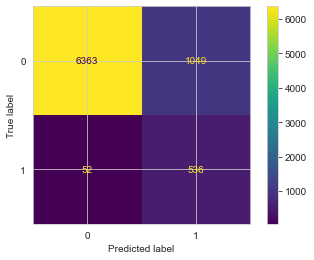

In [87]:
plot_confusion_matrix(lgbm, X_test, y_test)
plt.show()

#### Maximum recall achieved - 91% with F1-score of 86% - which is also shown on the confusion matrix
#### The 5-fold cross validation suggests that accuracy should be around [0.87, 0.89]. Our F1 score of 86% that falls around the validation numbers.

#### Based on the modeling so far, LGBM gives the highest recall values for class 1. Lets try hyperparameter tuning to potentially improve our results.

## Hyperparameter Tuning

In [73]:
gridParams = {
    'learning_rate': [0.02,0.04],
    'n_estimators': [6,8,16],
    'num_leaves': [16,18,20,22], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['binary'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'colsample_bytree' : [0.62, 0.64, 0.65],
    'subsample' : [0.65,0.7],
    'reg_alpha' : [1.2,1.4],
    'reg_lambda' : [0.6,0.8,1],
    }


In [74]:
grid = GridSearchCV(lgbm, gridParams, verbose=1, cv=5, n_jobs=-1, scoring='recall')
# Run the grid
grid.fit(X_rus, y_rus)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 7056 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 9656 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 12656 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 14336 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 16236 tasks      | elapsed:  7.2min


{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.04, 'max_bin': 510, 'n_estimators': 16, 'num_leaves': 22, 'objective': 'binary', 'random_state': 500, 'reg_alpha': 1.2, 'reg_lambda': 0.8, 'subsample': 0.65}
0.8630954728568611


[Parallel(n_jobs=-1)]: Done 17280 out of 17280 | elapsed:  7.7min finished


#### In this case, Hyperparmeter tuning has not helped our LGBM model, our best result still remains highest recall for class 1 at 91%.


## Feature Importance


#### 1. LGBM - Feature importance plot

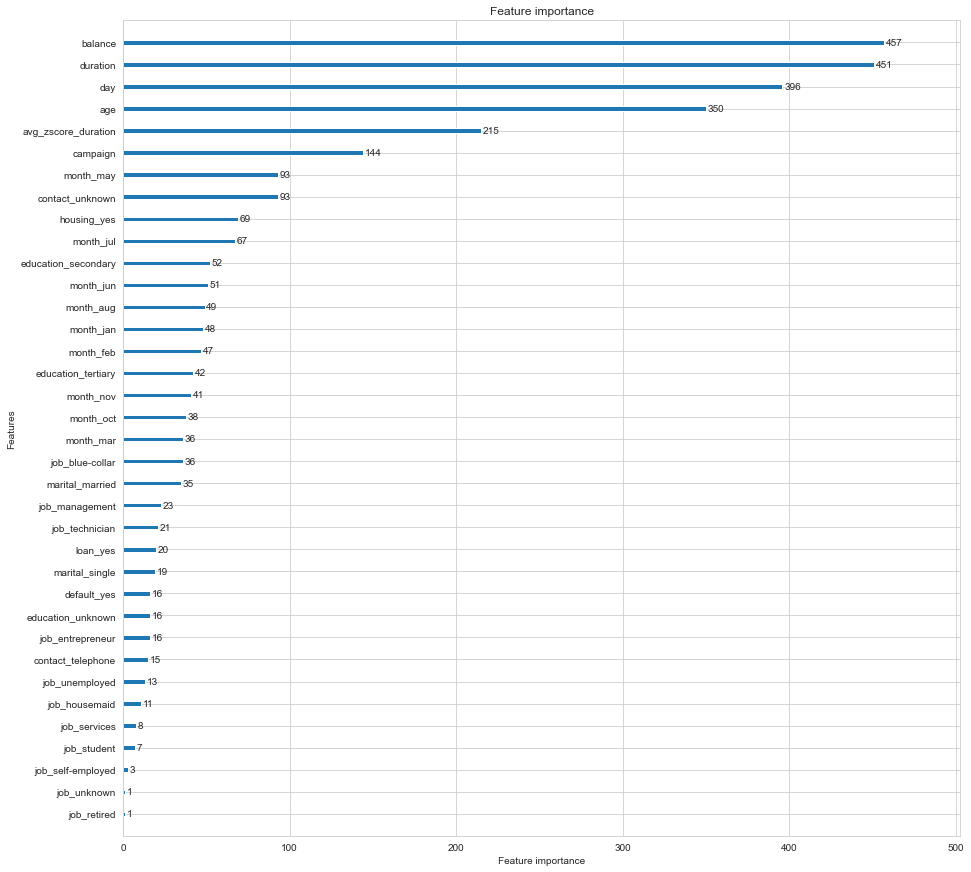

In [76]:
ax = lightgbm.plot_importance(lgbm, max_num_features=40, figsize=(15,15))
plt.show()

#### 2. Recursive Feature Elimination (RFECV)

#### RFECV iterately remove less important variables and finally arrive at an optimal model with few important features

In [77]:
rfecv = RFECV(estimator = rfc, step = 1, cv = StratifiedKFold(10), scoring = 'recall')  
rfecv.fit(X_rus,y_rus)                                                                                   


RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(n_jobs=2, random_state=12),
      scoring='recall')

In [78]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 36


In [79]:
rfecv.estimator.feature_importances_

array([4.17103426e-02, 5.10923577e-02, 5.43544457e-02, 2.72207365e-01,
       2.53668397e-02, 7.85110012e-03, 2.35318033e-03, 2.15427358e-03,
       5.78448362e-03, 2.30557529e-03, 1.90006854e-03, 4.15332304e-03,
       2.57638032e-03, 5.96356827e-03, 2.60980552e-03, 8.08535092e-04,
       7.86206798e-03, 6.23562895e-03, 7.48403048e-03, 8.25512266e-03,
       3.22043601e-03, 1.05535919e-03, 1.80677693e-02, 5.98909032e-03,
       4.13182281e-03, 2.82019574e-02, 1.21026069e-02, 1.31837107e-04,
       8.84050081e-03, 5.28744331e-03, 1.56713481e-02, 7.36851006e-03,
       1.59647405e-02, 1.03026341e-02, 7.26883508e-03, 8.19781596e-03,
       4.32387016e-02, 5.14926019e-02, 2.40437495e-01])

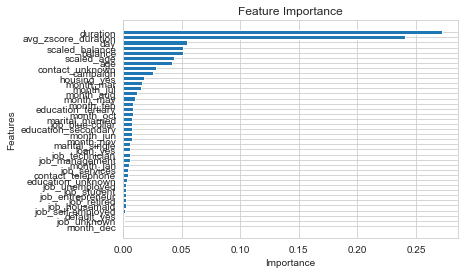

In [88]:
sorted_idx = rfecv.estimator.feature_importances_.argsort()                          
plt.barh(X.columns[sorted_idx], rfecv.estimator.feature_importances_[sorted_idx])   
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

#### From the above feature importance, we see that duration and balance are the most positively influential parameters. People who are more likely to subscribe have higher account balance and high call duration in the last call.

## PCA - Principal Component Analysis

#### As we can see, we currently have 30+ variables in the dataset. We want to see whether we can reduce the dimensions and increase interpretability of clusters.

In [89]:
#PCA
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(data_dc)

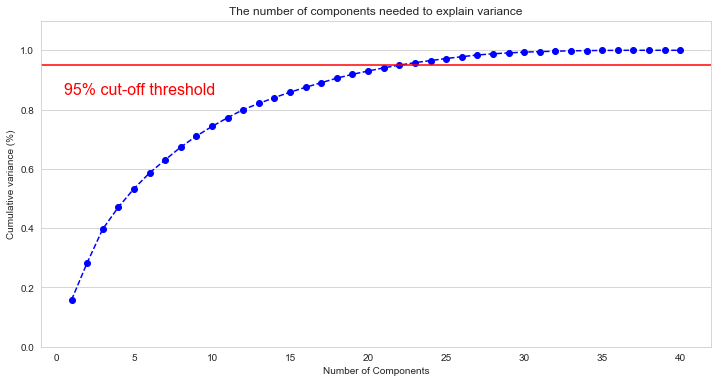

In [90]:
pca = PCA().fit(data_rescaled)

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 41, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

#### In this case, to get 95% of variance explained we need 22 principal components.

## Conclusion

#### Evaluation Metric: Recall - 91%, Accuracy - 86%
#### Best Performing Model: LGBM
#### Important Features: Duration, Balance (People who are more likely to subscribe have higher account balance and high call duration in the last call)
#### 22 principal components are required to explain 95% of variance in the dataset. That is, it is not possible to reduce the dimension significantly for this dataset.